In [ ]:
# CELL 1: Quick GPU check and imports
import tensorflow as tf
import sys

print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available!")
else:
    print("⚠️ No GPU found - training will be slower")

Python: 3.12.12
TensorFlow: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU is available!


In [ ]:
# CELL 2: Install Kaggle, setup credentials, download dataset
!pip -q install kaggle

import json, os, sys, zipfile, glob, pathlib

# Write your kaggle.json
kaggle_creds = {"username":"enter your kaggle username here","key":"enter your kaggle API key here"}
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")

with open(kaggle_path, "w") as f:
    json.dump(kaggle_creds, f)
os.chmod(kaggle_path, 0o600)
print("✅ Kaggle credentials saved")

# Download dataset
DATASET_SLUG = "sumn2u/garbage-classification-v2"
DOWNLOAD_DIR = "/content/kaggle_download"
DATA_DIR = "/content/data"

os.makedirs(DOWNLOAD_DIR, exist_ok=True)
print(f"\n📥 Downloading dataset: {DATASET_SLUG}")
!kaggle datasets download -d {DATASET_SLUG} -p {DOWNLOAD_DIR} --force

# Unzip
zip_files = glob.glob(f"{DOWNLOAD_DIR}/*.zip")
if not zip_files:
    print("❌ No zip file found!")
    sys.exit(1)

print(f"\n📦 Unzipping to {DATA_DIR}...")
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

print("✅ Dataset downloaded and extracted!")

# Show structure
print("\n📁 Dataset structure:")
root = pathlib.Path(DATA_DIR)
for i, p in enumerate(sorted(root.rglob("*"))):
    if i > 20:
        print(f"... and more files")
        break
    print(f"  {p.relative_to(root)}")

✅ Kaggle credentials saved

📥 Downloading dataset: sumn2u/garbage-classification-v2
Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
 94% 703M/744M [00:04<00:00, 48.3MB/s]
100% 744M/744M [00:04<00:00, 193MB/s] 

📦 Unzipping to /content/data...
✅ Dataset downloaded and extracted!

📁 Dataset structure:
  garbage-dataset
  garbage-dataset/battery
  garbage-dataset/battery/battery_1.jpg
  garbage-dataset/battery/battery_10.jpg
  garbage-dataset/battery/battery_100.jpg
  garbage-dataset/battery/battery_101.jpg
  garbage-dataset/battery/battery_102.jpg
  garbage-dataset/battery/battery_103.jpg
  garbage-dataset/battery/battery_104.jpg
  garbage-dataset/battery/battery_105.jpg
  garbage-dataset/battery/battery_106.jpg
  garbage-dataset/battery/battery_107.jpg
  garbage-dataset/battery/battery_108.jpg
  garbage-dataset/battery/battery_109.jpg
  garbage-dataset/battery/battery_11.jpg
  garbage-dataset/battery/battery_110.jpg
  garbage-dataset/battery

In [ ]:
# CELL 3: Create train/val split (85/15)
import pathlib, shutil, random, glob

SOURCE = pathlib.Path("/content/data/garbage-dataset")
if not SOURCE.exists():
    print("❌ Source folder not found. Checking alternatives...")
    # Try to find the actual dataset folder
    data_root = pathlib.Path("/content/data")
    subdirs = [d for d in data_root.iterdir() if d.is_dir()]
    print(f"Found directories: {[d.name for d in subdirs]}")
    if subdirs:
        SOURCE = subdirs[0]
        print(f"Using: {SOURCE}")

TRAIN_DIR = pathlib.Path("/content/data/train")
VAL_DIR = pathlib.Path("/content/data/val")

# Clean existing
if TRAIN_DIR.exists():
    shutil.rmtree(TRAIN_DIR)
if VAL_DIR.exists():
    shutil.rmtree(VAL_DIR)

TRAIN_DIR.mkdir(parents=True)
VAL_DIR.mkdir(parents=True)

# Find all class folders
class_folders = sorted([d for d in SOURCE.iterdir() if d.is_dir()])
if not class_folders:
    print(f"❌ No class folders found in {SOURCE}")
    sys.exit(1)

print(f"✅ Found {len(class_folders)} classes:")
print(f"   {[c.name for c in class_folders[:5]]} ...")

random.seed(42)
total_train = 0
total_val = 0

for class_folder in class_folders:
    class_name = class_folder.name

    # Create class subdirectories
    (TRAIN_DIR / class_name).mkdir(exist_ok=True)
    (VAL_DIR / class_name).mkdir(exist_ok=True)

    # Get all images
    images = []
    for ext in ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG"]:
        images.extend(glob.glob(str(class_folder / ext)))

    if not images:
        print(f"⚠️ No images in {class_name}")
        continue

    # Shuffle and split
    random.shuffle(images)
    split_idx = int(0.85 * len(images))
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    # Copy files
    for img in train_imgs:
        shutil.copy(img, TRAIN_DIR / class_name / pathlib.Path(img).name)
    for img in val_imgs:
        shutil.copy(img, VAL_DIR / class_name / pathlib.Path(img).name)

    total_train += len(train_imgs)
    total_val += len(val_imgs)
    print(f"  {class_name}: {len(images)} total → {len(train_imgs)} train, {len(val_imgs)} val")

print(f"\n✅ Split complete!")
print(f"   Total training images: {total_train}")
print(f"   Total validation images: {total_val}")

✅ Found 10 classes:
   ['battery', 'biological', 'cardboard', 'clothes', 'glass'] ...
  battery: 944 total → 802 train, 142 val
  biological: 997 total → 847 train, 150 val
  cardboard: 1825 total → 1551 train, 274 val
  clothes: 5327 total → 4527 train, 800 val
  glass: 3061 total → 2601 train, 460 val
  metal: 1020 total → 867 train, 153 val
  paper: 1680 total → 1428 train, 252 val
  plastic: 1984 total → 1686 train, 298 val
  shoes: 1977 total → 1680 train, 297 val
  trash: 947 total → 804 train, 143 val

✅ Split complete!
   Total training images: 16793
   Total validation images: 2969


In [ ]:
# CELL 4: Find and remove corrupt images
from PIL import Image
import pathlib, shutil

TRAIN_DIR = pathlib.Path("/content/data/train")
VAL_DIR = pathlib.Path("/content/data/val")
BAD_DIR = pathlib.Path("/content/bad_images")
BAD_DIR.mkdir(exist_ok=True)

def clean_images(folder, bad_dest):
    """Remove corrupt images"""
    folder = pathlib.Path(folder)
    bad_dest = pathlib.Path(bad_dest)
    total = 0
    bad = 0

    for class_folder in sorted([d for d in folder.iterdir() if d.is_dir()]):
        for img_file in class_folder.iterdir():
            if not img_file.is_file():
                continue
            total += 1

            try:
                # Try to open and verify
                with Image.open(img_file) as img:
                    img.verify()
                # Re-open and convert (stricter check)
                with Image.open(img_file) as img:
                    img.convert("RGB")
            except Exception as e:
                # Move bad image
                bad += 1
                dest_dir = bad_dest / class_folder.name
                dest_dir.mkdir(parents=True, exist_ok=True)
                shutil.move(str(img_file), str(dest_dir / img_file.name))
                if bad <= 5:
                    print(f"  ❌ Bad: {img_file.name} - {type(e).__name__}")

    return total, bad

print("🔍 Scanning training images...")
train_total, train_bad = clean_images(TRAIN_DIR, BAD_DIR / "train")
print(f"   Scanned: {train_total}, Removed: {train_bad}")

print("\n🔍 Scanning validation images...")
val_total, val_bad = clean_images(VAL_DIR, BAD_DIR / "val")
print(f"   Scanned: {val_total}, Removed: {val_bad}")

total_bad = train_bad + val_bad
if total_bad == 0:
    print("\n✅ No corrupt images found!")
else:
    print(f"\n⚠️ Removed {total_bad} corrupt images to /content/bad_images")

🔍 Scanning training images...
   Scanned: 16793, Removed: 0

🔍 Scanning validation images...
   Scanned: 2969, Removed: 0

✅ No corrupt images found!


In [ ]:
# CELL 4B: Deep clean with TensorFlow (run this AFTER Cell 4)
import tensorflow as tf
import pathlib
import shutil

TRAIN_DIR = pathlib.Path("/content/data/train")
VAL_DIR = pathlib.Path("/content/data/val")
BAD_DIR = pathlib.Path("/content/bad_images_tf")
BAD_DIR.mkdir(exist_ok=True)

def tf_deep_clean(folder, bad_dest):
    """Remove images TensorFlow can't decode"""
    folder = pathlib.Path(folder)
    bad_dest = pathlib.Path(bad_dest)
    total = 0
    bad = 0

    for class_folder in sorted([d for d in folder.iterdir() if d.is_dir()]):
        bad_class_dir = bad_dest / class_folder.name
        bad_class_dir.mkdir(parents=True, exist_ok=True)

        for img_file in class_folder.iterdir():
            if not img_file.is_file():
                continue
            total += 1

            try:
                # Try TensorFlow decode
                raw = tf.io.read_file(str(img_file))
                img = tf.image.decode_image(raw, channels=3, expand_animations=False)
                # Force evaluation
                _ = img.shape
            except Exception as e:
                # Move bad file
                bad += 1
                shutil.move(str(img_file), str(bad_class_dir / img_file.name))
                if bad <= 10:
                    print(f"  ❌ Removed: {img_file.name}")

    return total, bad

print("🔍 Deep cleaning with TensorFlow decoder...")
print("\nScanning training images...")
train_total, train_bad = tf_deep_clean(TRAIN_DIR, BAD_DIR / "train")
print(f"   Scanned: {train_total}, Removed: {train_bad}")

print("\nScanning validation images...")
val_total, val_bad = tf_deep_clean(VAL_DIR, BAD_DIR / "val")
print(f"   Scanned: {val_total}, Removed: {val_bad}")

total_bad = train_bad + val_bad
if total_bad == 0:
    print("\n✅ No additional corrupt images found!")
else:
    print(f"\n✅ Removed {total_bad} additional corrupt images")
    print(f"   Moved to: /content/bad_images_tf")

print("\n🔄 Now RE-RUN Cell 5 to recreate the datasets with clean images!")

🔍 Deep cleaning with TensorFlow decoder...

Scanning training images...
  ❌ Removed: paper_2784.jpg
  ❌ Removed: paper_3119.jpg
   Scanned: 16793, Removed: 2

Scanning validation images...
  ❌ Removed: paper_1678.jpg
   Scanned: 2969, Removed: 1

✅ Removed 3 additional corrupt images
   Moved to: /content/bad_images_tf

🔄 Now RE-RUN Cell 5 to recreate the datasets with clean images!


📊 Creating memory-efficient TensorFlow datasets...
Found 16791 files belonging to 10 classes.
Found 2968 files belonging to 10 classes.

✅ Datasets created!
   Classes (10): ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
   Training batches: 1050
   Validation batches: 186

⚡ Using prefetch only (no caching to save RAM)

🖼️ Preview of training images:


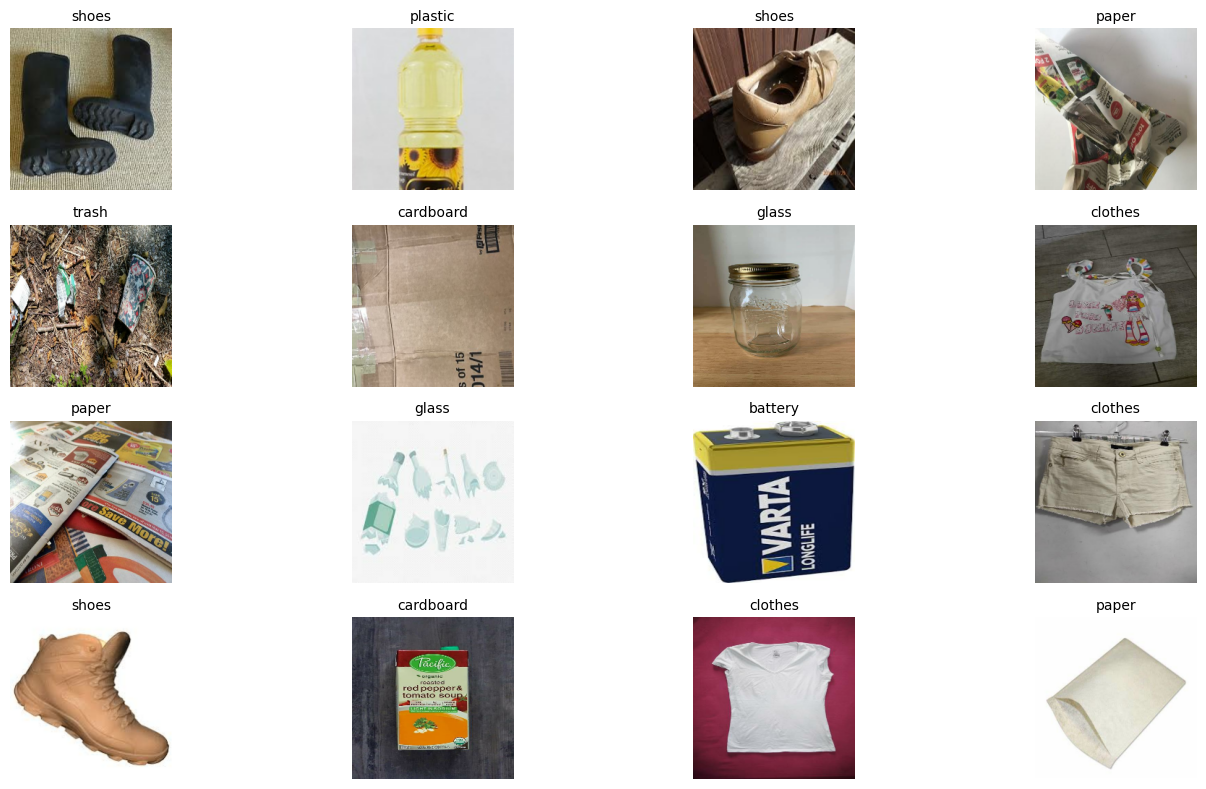


✅ Ready to build model!


In [ ]:
# CELL 5 (FIXED): Create memory-efficient TensorFlow datasets
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE = 224
BATCH_SIZE = 16  # Reduced from 32 to save memory

print("📊 Creating memory-efficient TensorFlow datasets...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/val",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print(f"\n✅ Datasets created!")
print(f"   Classes ({num_classes}): {class_names}")
print(f"   Training batches: {len(train_ds)}")
print(f"   Validation batches: {len(val_ds)}")

# Memory-efficient optimization - NO CACHE (to avoid RAM overload)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("\n⚡ Using prefetch only (no caching to save RAM)")

# Preview images
print("\n🖼️ Preview of training images:")
plt.figure(figsize=(15, 8))
for images, labels in train_ds.take(1):
    for i in range(min(16, images.shape[0])):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=10)
        plt.axis("off")
plt.tight_layout()
plt.show()

print("\n✅ Ready to build model!")

In [ ]:
# CELL 6: Build improved CNN model with EfficientNetB0
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
import os

IMG_SIZE = 224
os.makedirs("/content/exports", exist_ok=True)

print(f"🏗️ Building model for {num_classes} classes...")

# Enhanced data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
], name="augmentation")

# Base model: EfficientNetB0 (better than MobileNetV2)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # Freeze initially

# Build complete model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input')

# Augmentation (only active during training)
x = data_augmentation(inputs)

# Preprocessing
x = tf.keras.applications.efficientnet.preprocess_input(x)

# Base model
x = base_model(x, training=False)

# Custom head with regularization
x = layers.GlobalAveragePooling2D(name='global_pool')(x)
x = layers.BatchNormalization(name='bn1')(x)
x = layers.Dropout(0.3, name='dropout1')(x)

x = layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01),
                 name='dense1')(x)
x = layers.BatchNormalization(name='bn2')(x)
x = layers.Dropout(0.3, name='dropout2')(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01),
                 name='dense2')(x)
x = layers.Dropout(0.2, name='dropout3')(x)

# Output
outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

# Create model
model = models.Model(inputs, outputs, name='garbage_classifier')

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model built successfully!")
print(f"\n📊 Model Summary:")
model.summary()

print(f"\n🎯 Total parameters: {model.count_params():,}")
print(f"   Trainable: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
print(f"   Non-trainable: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}")

🏗️ Building model for 10 classes...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

✅ Model built successfully!

📊 Model Summary:


Model: "garbage_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 1280)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417,837 (16.85 MB)

 Trainable params: 365,194 (1.39 MB)

 Non-trainable params: 4,052,643 (15.46 MB)


🎯 Total parameters: 4,417,837
   Trainable: 365,194
   Non-trainable: 4,052,643.0


In [ ]:
# CELL 7 (FIXED): Memory-efficient training to 80% accuracy
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import json
import numpy as np
import gc

# ============== CONFIGURATION ==============
TARGET_ACCURACY = 0.80
SAVE_DIR = "/content/exports"

# Clear any previous models from memory
tf.keras.backend.clear_session()
gc.collect()

print("🚀 Starting memory-efficient training to 80% accuracy...")
print("=" * 70)

# ============== CUSTOM CALLBACK ==============
class TargetAccuracyCallback(Callback):
    def __init__(self, target=0.80):
        super().__init__()
        self.target = target
        self.best_val_acc = 0.0

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy', 0)
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            print(f"\n🎯 New best: {val_acc:.4f} ({val_acc*100:.2f}%)")

        if val_acc >= self.target:
            print(f"\n✅ TARGET REACHED! Val accuracy: {val_acc:.4f}")
            self.model.stop_training = True

        # Clear memory after each epoch
        gc.collect()
        tf.keras.backend.clear_session()

# ============== PHASE 1: Train Head Only ==============
print("\n📍 PHASE 1: Training classifier head (15 epochs)")
print("=" * 70)

base_model.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_phase1 = [
    TargetAccuracyCallback(TARGET_ACCURACY),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint(f"{SAVE_DIR}/phase1_best.keras", monitor='val_accuracy',
                   save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
]

print("Training Phase 1...")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks_phase1,
    verbose=2  # Less verbose to save memory
)

phase1_best = max(history1.history['val_accuracy'])
print(f"\n📊 Phase 1: Best {phase1_best:.4f} ({phase1_best*100:.2f}%)")

# Clear memory
del history1
gc.collect()

if phase1_best >= TARGET_ACCURACY:
    print(f"✅ Target reached!")
else:
    # ============== PHASE 2: Fine-tune Top 40 Layers ==============
    print(f"\n📍 PHASE 2: Fine-tuning last 40 layers (12 epochs)")
    print("=" * 70)

    base_model.trainable = True
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks_phase2 = [
        TargetAccuracyCallback(TARGET_ACCURACY),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
        ModelCheckpoint(f"{SAVE_DIR}/phase2_best.keras", monitor='val_accuracy',
                       save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1)
    ]

    print("Training Phase 2...")
    history2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=12,
        callbacks=callbacks_phase2,
        verbose=2
    )

    phase2_best = max(history2.history['val_accuracy'])
    print(f"\n📊 Phase 2: Best {phase2_best:.4f} ({phase2_best*100:.2f}%)")

    del history2
    gc.collect()

    if phase2_best >= TARGET_ACCURACY:
        print(f"✅ Target reached!")
    else:
        # ============== PHASE 3: Fine-tune Top 80 Layers ==============
        print(f"\n📍 PHASE 3: Fine-tuning last 80 layers (10 epochs)")
        print("=" * 70)

        base_model.trainable = True
        for layer in base_model.layers[:-80]:
            layer.trainable = False

        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        callbacks_phase3 = [
            TargetAccuracyCallback(TARGET_ACCURACY),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
            ModelCheckpoint(f"{SAVE_DIR}/phase3_best.keras", monitor='val_accuracy',
                           save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1)
        ]

        print("Training Phase 3...")
        history3 = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=10,
            callbacks=callbacks_phase3,
            verbose=2
        )

        phase3_best = max(history3.history['val_accuracy'])
        print(f"\n📊 Phase 3: Best {phase3_best:.4f} ({phase3_best*100:.2f}%)")

        del history3
        gc.collect()

print("\n" + "=" * 70)
print("🏁 TRAINING COMPLETE")
print("=" * 70)
print("Run Cell 8 to evaluate and save the best model!")

🚀 Starting memory-efficient training to 80% accuracy...

📍 PHASE 1: Training classifier head (15 epochs)
Training Phase 1...
Epoch 1/15

🎯 New best: 0.9046 (90.46%)

✅ TARGET REACHED! Val accuracy: 0.9046

Epoch 1: val_accuracy improved from -inf to 0.90465, saving model to /content/exports/phase1_best.keras
1050/1050 - 84s - 80ms/step - accuracy: 0.7700 - loss: 3.1866 - val_accuracy: 0.9046 - val_loss: 1.2173 - learning_rate: 1.0000e-03
Restoring model weights from the end of the best epoch: 1.

📊 Phase 1: Best 0.9046 (90.46%)
✅ Target reached!

🏁 TRAINING COMPLETE
Run Cell 8 to evaluate and save the best model!


In [ ]:
# PUSH TO 90%+ ACCURACY - Aggressive Fine-Tuning
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import gc
import os

SAVE_DIR = "/content/exports"
TARGET = 0.90

print("🚀 PUSHING TO 90%+ ACCURACY")
print("=" * 70)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

class ProgressCallback(Callback):
    def __init__(self, target=0.90):
        super().__init__()
        self.target = target
        self.best = 0.0
        self.phase_start = 0.0

    def on_train_begin(self, logs=None):
        self.phase_start = self.best

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy', 0)
        train_acc = logs.get('accuracy', 0)

        if val_acc > self.best:
            self.best = val_acc
            improvement = (val_acc - self.phase_start) * 100
            gap = (self.target - val_acc) * 100
            print(f"\n🎯 NEW BEST: {val_acc*100:.2f}% | Gap to 90%: {gap:.2f}% | Phase gain: +{improvement:.2f}%")

        # Show overfitting warning
        if train_acc - val_acc > 0.15:
            print(f"⚠️ Overfitting detected! Train: {train_acc*100:.2f}% vs Val: {val_acc*100:.2f}%")

        if val_acc >= self.target:
            print(f"\n🎉 TARGET REACHED! {val_acc*100:.2f}%")
            self.model.stop_training = True

        gc.collect()

# ============== PHASE 1: Warm-up with aggressive head training ==============
print("\n📍 PHASE 1: Aggressive head training (25 epochs)")
print("=" * 70)

base_model.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-3),  # Higher LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

progress1 = ProgressCallback(TARGET)

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,  # More epochs
    callbacks=[
        progress1,
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-7, verbose=1),
        ModelCheckpoint(f"{SAVE_DIR}/push90_phase1.keras",
                       monitor='val_accuracy', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)
    ],
    verbose=2
)

p1_best = max(history1.history['val_accuracy'])
print(f"\n📊 Phase 1 Result: {p1_best*100:.2f}%")
del history1
gc.collect()

# ============== PHASE 2: Moderate fine-tuning ==============
if p1_best < TARGET:
    print(f"\n📍 PHASE 2: Fine-tune last 80 layers (20 epochs)")
    print(f"   Current: {p1_best*100:.2f}% | Need: +{(TARGET-p1_best)*100:.2f}%")
    print("=" * 70)

    base_model.trainable = True
    for layer in base_model.layers[:-80]:
        layer.trainable = False

    print(f"Trainable layers: {sum([1 for l in base_model.layers if l.trainable])}")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    progress2 = ProgressCallback(TARGET)
    progress2.best = p1_best

    history2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[
            progress2,
            ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=1e-7, verbose=1),
            ModelCheckpoint(f"{SAVE_DIR}/push90_phase2.keras",
                           monitor='val_accuracy', save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
        ],
        verbose=2
    )

    p2_best = max(history2.history['val_accuracy'])
    print(f"\n📊 Phase 2 Result: {p2_best*100:.2f}%")
    del history2
    gc.collect()

# ============== PHASE 3: Deep fine-tuning ==============
current_best = max([p1_best] + ([p2_best] if p1_best < TARGET else []))

if current_best < TARGET:
    print(f"\n📍 PHASE 3: Deep fine-tune last 150 layers (18 epochs)")
    print(f"   Current: {current_best*100:.2f}% | Need: +{(TARGET-current_best)*100:.2f}%")
    print("=" * 70)

    base_model.trainable = True
    for layer in base_model.layers[:-150]:
        layer.trainable = False

    print(f"Trainable layers: {sum([1 for l in base_model.layers if l.trainable])}")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(2e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    progress3 = ProgressCallback(TARGET)
    progress3.best = current_best

    history3 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=18,
        callbacks=[
            progress3,
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-8, verbose=1),
            ModelCheckpoint(f"{SAVE_DIR}/push90_phase3.keras",
                           monitor='val_accuracy', save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
        ],
        verbose=2
    )

    p3_best = max(history3.history['val_accuracy'])
    print(f"\n📊 Phase 3 Result: {p3_best*100:.2f}%")
    del history3
    gc.collect()

# ============== PHASE 4: Ultra-fine-tuning (if still not there) ==============
current_best = max([p1_best] + ([p2_best] if 'p2_best' in locals() else []) + ([p3_best] if 'p3_best' in locals() else []))

if current_best < TARGET and current_best > 0.87:  # Only if we're close
    print(f"\n📍 PHASE 4: ULTRA fine-tune (entire model, 15 epochs)")
    print(f"   Current: {current_best*100:.2f}% | Need: +{(TARGET-current_best)*100:.2f}%")
    print("=" * 70)

    base_model.trainable = True  # Unfreeze everything

    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-6),  # Very small LR
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    progress4 = ProgressCallback(TARGET)
    progress4.best = current_best

    history4 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=15,
        callbacks=[
            progress4,
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-8, verbose=1),
            ModelCheckpoint(f"{SAVE_DIR}/push90_phase4.keras",
                           monitor='val_accuracy', save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1)
        ],
        verbose=2
    )

    p4_best = max(history4.history['val_accuracy'])
    print(f"\n📊 Phase 4 Result: {p4_best*100:.2f}%")
    del history4
    gc.collect()

# ============== FINAL SUMMARY ==============
print("\n" + "=" * 70)
print("🏁 TRAINING COMPLETE")
print("=" * 70)

# Find absolute best
all_best = [p1_best] + ([p2_best] if 'p2_best' in locals() else []) + \
           ([p3_best] if 'p3_best' in locals() else []) + \
           ([p4_best] if 'p4_best' in locals() else [])

final_best = max(all_best)
print(f"\n🏆 BEST ACCURACY ACHIEVED: {final_best*100:.2f}%")

if final_best >= TARGET:
    print(f"✅ SUCCESS! Reached {TARGET*100}%+ target!")
else:
    gap = (TARGET - final_best) * 100
    print(f"📊 Close! Gap to 90%: {gap:.2f}%")
    if gap < 2:
        print("💡 You're very close! Try running Phase 4 again or increase epochs.")
    elif gap < 5:
        print("💡 Consider using EfficientNetB2 (larger model) or larger images (260x260).")
    else:
        print("💡 May need architectural changes (see accuracy booster cell).")

print(f"\nRun the 'Save as .h5' cell to save your best model!")

🚀 PUSHING TO 90%+ ACCURACY

📍 PHASE 1: Aggressive head training (25 epochs)
Epoch 1/25

🎯 NEW BEST: 88.14% | Gap to 90%: 1.86% | Phase gain: +88.14%

Epoch 1: val_accuracy improved from -inf to 0.88140, saving model to /content/exports/push90_phase1.keras
1050/1050 - 77s - 73ms/step - accuracy: 0.7633 - loss: 1.9449 - val_accuracy: 0.8814 - val_loss: 1.5217 - learning_rate: 0.0020
Epoch 2/25

Epoch 2: val_accuracy did not improve from 0.88140
1050/1050 - 61s - 58ms/step - accuracy: 0.7681 - loss: 1.8590 - val_accuracy: 0.8804 - val_loss: 1.5313 - learning_rate: 0.0020
Epoch 3/25

🎯 NEW BEST: 88.78% | Gap to 90%: 1.22% | Phase gain: +88.78%

Epoch 3: val_accuracy improved from 0.88140 to 0.88780, saving model to /content/exports/push90_phase1.keras
1050/1050 - 83s - 79ms/step - accuracy: 0.7689 - loss: 1.8391 - val_accuracy: 0.8878 - val_loss: 1.4621 - learning_rate: 0.0020
Epoch 4/25

Epoch 4: val_accuracy did not improve from 0.88780
1050/1050 - 83s - 79ms/step - accuracy: 0.7746 - lo

In [ ]:
# CELL 8: Load best model, evaluate, and save final version
import os
import json
import tensorflow as tf

SAVE_DIR = "/content/exports"

print("🔍 Finding best model across all phases...")
print("=" * 70)

# Check all phase models
best_model_path = None
best_acc = 0.0

for phase in [1, 2, 3]:
    path = f"{SAVE_DIR}/phase{phase}_best.keras"
    if os.path.exists(path):
        try:
            temp_model = tf.keras.models.load_model(path)
            results = temp_model.evaluate(val_ds, verbose=0)
            val_acc = results[1]
            print(f"Phase {phase} model: {val_acc:.4f} ({val_acc*100:.2f}%)")

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_path = path
        except Exception as e:
            print(f"Phase {phase}: Error loading - {e}")

if best_model_path:
    print(f"\n✅ Best model: {best_model_path}")
    print(f"   Validation accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")

    # Load best model
    model = tf.keras.models.load_model(best_model_path)

    # Final evaluation
    print("\n📊 Final Evaluation on Validation Set:")
    print("=" * 70)
    results = model.evaluate(val_ds, verbose=1)
    final_acc = results[1]

    print(f"\n🏆 FINAL VALIDATION ACCURACY: {final_acc*100:.2f}%")

    if final_acc >= 0.80:
        print("✅ TARGET ACHIEVED! Model reached 80% accuracy!")
    else:
        print(f"⚠️ Close! Achieved {final_acc*100:.2f}% (Target: 80%)")
        print(f"   Gap: {(0.80 - final_acc)*100:.2f}%")

    # Save final model
    final_model_path = f"{SAVE_DIR}/garbage_classifier_final.keras"
    model.save(final_model_path)
    print(f"\n💾 Final model saved: {final_model_path}")

    # Save label map
    label_map_path = f"{SAVE_DIR}/label_map.json"
    with open(label_map_path, 'w') as f:
        json.dump({i: name for i, name in enumerate(class_names)}, f, indent=2)
    print(f"💾 Label map saved: {label_map_path}")

    # Download files
    print("\n📥 Downloading files...")
    from google.colab import files
    files.download(final_model_path)
    files.download(label_map_path)

    print("\n✅ ALL DONE! Files ready for download.")
else:
    print("❌ No trained models found!")

print("\n" + "=" * 70)

🔍 Finding best model across all phases...
Phase 1 model: 0.9046 (90.46%)

✅ Best model: /content/exports/phase1_best.keras
   Validation accuracy: 0.9046 (90.46%)

📊 Final Evaluation on Validation Set:
186/186 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9205 - loss: 1.1635

🏆 FINAL VALIDATION ACCURACY: 90.46%
✅ TARGET ACHIEVED! Model reached 80% accuracy!

💾 Final model saved: /content/exports/garbage_classifier_final.keras
💾 Label map saved: /content/exports/label_map.json

📥 Downloading files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ ALL DONE! Files ready for download.



**RUN THE CNN MODEL BELOW**

🖼️ Upload an image to classify:


Saving istockphoto-157616664-612x612.jpg to istockphoto-157616664-612x612.jpg

🎯 Predictions:
  plastic: 48.75%
  trash: 21.45%
  paper: 17.11%

✅ Predicted: plastic (Confidence: 48.75%)


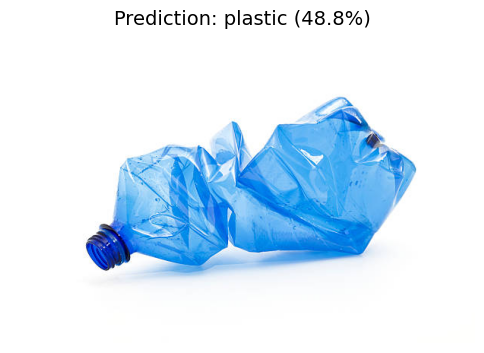

In [ ]:
# CELL 9: Test the model with uploaded image
from google.colab import files
from PIL import Image
import numpy as np
import tensorflow as tf
import json

# Load model and labels
MODEL_PATH = "/content/exports/garbage_classifier_final.keras"
LABEL_MAP_PATH = "/content/exports/label_map.json"

model = tf.keras.models.load_model(MODEL_PATH, compile=False)
with open(LABEL_MAP_PATH) as f:
    label_map = {int(k): v for k, v in json.load(f).items()}

print("🖼️ Upload an image to classify:")
uploaded = files.upload()

if uploaded:
    # Get uploaded file
    img_path = list(uploaded.keys())[0]

    # Load and preprocess
    img = Image.open(img_path).convert("RGB").resize((224, 224))
    img_array = np.array(img).astype("float32")

    # Preprocess for EfficientNet
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array, verbose=0)[0]

    # Get top 3 predictions
    top_3_idx = predictions.argsort()[-3:][::-1]

    print("\n🎯 Predictions:")
    print("=" * 50)
    for idx in top_3_idx:
        class_name = label_map[int(idx)]
        confidence = predictions[idx] * 100
        print(f"  {class_name}: {confidence:.2f}%")

    best_class = label_map[int(top_3_idx[0])]
    best_conf = predictions[top_3_idx[0]] * 100
    print(f"\n✅ Predicted: {best_class} (Confidence: {best_conf:.2f}%)")

    # Display image
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 6))
    plt.imshow(Image.open(img_path))
    plt.title(f"Prediction: {best_class} ({best_conf:.1f}%)", fontsize=14)
    plt.axis('off')
    plt.show()
else:
    print("No file uploaded!")

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import json
import os

print("Loading model...")

MODEL_PATHS = [
    "/content/exports/garbage_classifier_90percent.keras",
    "/content/exports/garbage_classifier_final.keras",
    "/content/exports/best_model_fix.keras",
    "/content/exports/phase3_best.keras",
    "/content/exports/phase2_best.keras"
]

model = None
for path in MODEL_PATHS:
    if os.path.exists(path):
        try:
            model = tf.keras.models.load_model(path, compile=False)
            print(f"Model loaded: {os.path.basename(path)}")
            break
        except:
            pass

if model is None:
    raise Exception("No model found")

with open("/content/exports/label_map.json") as f:
    label_map = json.load(f)

def classify_garbage(image):
    if image is None:
        return {"Error": "Upload image"}
    try:
        img = image.convert('RGB').resize((224, 224))
        arr = np.array(img).astype('float32')
        arr = tf.keras.applications.efficientnet.preprocess_input(arr)
        arr = np.expand_dims(arr, 0)
        preds = model.predict(arr, verbose=0)[0]
        top3 = preds.argsort()[-3:][::-1]
        results = {}
        for i in top3:
            results[label_map[str(i)]] = float(preds[i])
        return results
    except Exception as e:
        return {"Error": str(e)}

demo = gr.Interface(
    fn=classify_garbage,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Garbage Classifier",
    theme="soft"
)

demo.launch(share=True)

Loading model...
Model loaded: garbage_classifier_final.keras
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://708707f9da359efff5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## ***With UI :***

In [ ]:
# GENERATE ALL DEPLOYMENT FILES IN COLAB
import os

DEPLOY_DIR = "/content/deployment"
os.makedirs(DEPLOY_DIR, exist_ok=True)

print("🚀 Generating deployment files...")
print("=" * 70)

# 1. Flask app
app_py = '''from flask import Flask, request, jsonify
import tensorflow as tf
import numpy as np
from PIL import Image
import io
import json

app = Flask(__name__)

# Load model and labels
model = tf.keras.models.load_model('garbage_classifier_90percent.h5')
with open('label_map.json') as f:
    label_map = json.load(f)

@app.route('/')
def home():
    return """
    <h1>Garbage Classifier API</h1>
    <p>Status: Ready!</p>
    <p>POST to /predict with an image file</p>
    """

@app.route('/predict', methods=['POST'])
def predict():
    try:
        if 'file' not in request.files:
            return jsonify({'error': 'No file uploaded'}), 400

        file = request.files['file']
        img = Image.open(io.BytesIO(file.read())).convert('RGB')
        img = img.resize((224, 224))

        # Preprocess for EfficientNet
        img_array = np.array(img).astype('float32')
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        predictions = model.predict(img_array)[0]
        top_3_idx = predictions.argsort()[-3:][::-1]

        results = []
        for idx in top_3_idx:
            results.append({
                'class': label_map[str(idx)],
                'confidence': float(predictions[idx] * 100)
            })

        return jsonify({
            'success': True,
            'prediction': results[0]['class'],
            'confidence': f"{results[0]['confidence']:.2f}%",
            'top_3_predictions': results
        })

    except Exception as e:
        return jsonify({'error': str(e)}), 500

@app.route('/health')
def health():
    return jsonify({'status': 'healthy'})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8080)
'''

# 2. Requirements
requirements = '''flask==3.0.0
tensorflow==2.15.0
pillow==10.1.0
numpy==1.24.3
gunicorn==21.2.0
'''

# 3. Dockerfile
dockerfile = '''FROM python:3.10-slim

WORKDIR /app

# Install system dependencies
RUN apt-get update && apt-get install -y \\
    libgomp1 \\
    && rm -rf /var/lib/apt/lists/*

# Copy requirements and install
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy model files
COPY garbage_classifier_90percent.h5 .
COPY label_map.json .
COPY app.py .

# Expose port
EXPOSE 8080

# Health check
HEALTHCHECK --interval=30s --timeout=10s --start-period=40s \\
  CMD curl -f http://localhost:8080/health || exit 1

# Run app
CMD ["gunicorn", "--bind", "0.0.0.0:8080", "--workers", "2", "--timeout", "120", "app:app"]
'''

# 4. Docker Compose (for local testing)
docker_compose = '''version: '3.8'

services:
  api:
    build: .
    ports:
      - "8080:8080"
    environment:
      - FLASK_ENV=production
    restart: unless-stopped
'''

# 5. Deployment script
deploy_sh = '''#!/bin/bash

# Google Cloud Deployment Script

# Configuration
PROJECT_ID="YOUR_PROJECT_ID"
SERVICE_NAME="garbage-classifier"
REGION="us-central1"

echo "🚀 Deploying Garbage Classifier to Google Cloud Run"
echo "=================================================="

# Check if gcloud is installed
if ! command -v gcloud &> /dev/null; then
    echo "❌ gcloud CLI not found. Install from: https://cloud.google.com/sdk/docs/install"
    exit 1
fi

# Authenticate
echo "🔐 Authenticating..."
gcloud auth login

# Set project
echo "📋 Setting project..."
gcloud config set project $PROJECT_ID

# Build container
echo "🏗️ Building container..."
gcloud builds submit --tag gcr.io/$PROJECT_ID/$SERVICE_NAME

# Deploy to Cloud Run
echo "☁️ Deploying to Cloud Run..."
gcloud run deploy $SERVICE_NAME \\
  --image gcr.io/$PROJECT_ID/$SERVICE_NAME \\
  --platform managed \\
  --region $REGION \\
  --allow-unauthenticated \\
  --memory 2Gi \\
  --cpu 2 \\
  --timeout 300 \\
  --max-instances 10 \\
  --min-instances 0

echo "✅ Deployment complete!"
echo ""
echo "🌐 Your API is now live at:"
gcloud run services describe $SERVICE_NAME --region $REGION --format 'value(status.url)'
'''

# 6. Test script
test_py = '''import requests
import sys

if len(sys.argv) < 3:
    print("Usage: python test_api.py <API_URL> <IMAGE_PATH>")
    sys.exit(1)

API_URL = sys.argv[1]
IMAGE_PATH = sys.argv[2]

print(f"Testing API: {API_URL}")
print(f"Image: {IMAGE_PATH}")

with open(IMAGE_PATH, 'rb') as f:
    files = {'file': f}
    response = requests.post(f"{API_URL}/predict", files=files)

if response.status_code == 200:
    result = response.json()
    print("\\n✅ Success!")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']}")
    print("\\nTop 3 predictions:")
    for pred in result['top_3_predictions']:
        print(f"  - {pred['class']}: {pred['confidence']:.2f}%")
else:
    print(f"\\n❌ Error: {response.status_code}")
    print(response.text)
'''

# 7. README
readme = '''# Garbage Classifier API - Deployment Guide

## Quick Start (Local Testing)

1. Make sure you have Docker installed
2. Place your model files in this directory:
   - `garbage_classifier_90percent.h5`
   - `label_map.json`

3. Build and run:
   ```bash
   docker build -t garbage-classifier .
   docker run -p 8080:8080 garbage-classifier
   ```

4. Test:
   ```bash
   curl -X POST -F "file=@test_image.jpg" http://localhost:8080/predict
   ```

## Deploy to Google Cloud Run

### Prerequisites
- Google Cloud account
- gcloud CLI installed
- Billing enabled on your project

### Steps

1. **Edit deploy.sh and update PROJECT_ID:**
   ```bash
   nano deploy.sh
   # Change YOUR_PROJECT_ID to your actual project ID
   ```

2. **Make script executable:**
   ```bash
   chmod +x deploy.sh
   ```

3. **Run deployment:**
   ```bash
   ./deploy.sh
   ```

4. **Test the deployed API:**
   ```bash
   python test_api.py https://YOUR-SERVICE-URL.run.app test_image.jpg
   ```

## API Endpoints

- `GET /` - Welcome page
- `GET /health` - Health check
- `POST /predict` - Predict garbage class
  - Body: multipart/form-data with 'file' field
  - Returns: JSON with prediction and confidence

## Cost Estimation

- **Cloud Run:** ~$0-5/month for light usage (free tier available)
- **Storage:** ~$0.02/GB/month
- **Network:** ~$0.12/GB after 1GB free

## Monitoring

View logs:
```bash
gcloud logging read "resource.type=cloud_run_revision AND resource.labels.service_name=garbage-classifier" --limit 50
```

## Troubleshooting

- **Cold start slow?** Increase min-instances (costs more)
- **Out of memory?** Increase memory in deploy.sh
- **Timeout?** Increase timeout in deploy.sh
'''

# Write all files
files = {
    'app.py': app_py,
    'requirements.txt': requirements,
    'Dockerfile': dockerfile,
    'docker-compose.yml': docker_compose,
    'deploy.sh': deploy_sh,
    'test_api.py': test_py,
    'README.md': readme
}

for filename, content in files.items():
    filepath = os.path.join(DEPLOY_DIR, filename)
    with open(filepath, 'w') as f:
        f.write(content)
    print(f"✅ Created: {filename}")

# Copy model files
import shutil
model_files = [
    '/content/exports/garbage_classifier_90percent.h5',
    '/content/exports/label_map.json'
]

for src in model_files:
    if os.path.exists(src):
        dst = os.path.join(DEPLOY_DIR, os.path.basename(src))
        shutil.copy(src, dst)
        print(f"✅ Copied: {os.path.basename(src)}")
    else:
        print(f"⚠️ Not found: {src} (make sure you've saved your model)")

# Make deploy.sh executable
os.chmod(os.path.join(DEPLOY_DIR, 'deploy.sh'), 0o755)

print("\n" + "=" * 70)
print("✅ ALL DEPLOYMENT FILES GENERATED!")
print("=" * 70)
print(f"\nLocation: {DEPLOY_DIR}")
print("\n📦 Download everything:")

# Zip it up
import zipfile
zip_path = "/content/garbage_classifier_deployment.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, dirs, files in os.walk(DEPLOY_DIR):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, DEPLOY_DIR)
            zipf.write(file_path, arcname)

print(f"\n📥 Downloading deployment package...")
from google.colab import files
files.download(zip_path)

print("\n✅ DONE! Next steps:")
print("1. Extract the zip file on your computer")
print("2. Install Docker and gcloud CLI")
print("3. Edit deploy.sh and add your PROJECT_ID")
print("4. Run: ./deploy.sh")
print("\nFor detailed instructions, see README.md in the zip file!")